In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.special import roots_laguerre
from scipy.integrate import quad
from math import factorial

import signature.tensor_algebra as ta
from signature.ode_integration import *

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color= ["#B56246", "#579F40", "#9A46B5", "#4699B5", "#B54662", "#D4A017", "#5b6c64", "#71074E", "#0033A0"])

We want to compare numerically the solution of the standard heat equation
$$
\partial_t u(t, x) = \dfrac12\partial_{xx}u(t, x), \quad u(0, x) = g(x),
$$
and its power series analogue
$$
\dot \ell_t = \dfrac12 D^2\ell_t, \quad \ell_0 = \ell^g,
$$
where $D$ is the shift operator $(\ell_0, \ell_1, \ell_2, \ldots) \mapsto (\ell_1, \ell_2, \ell_3, \ldots)$, and
$$
g(x) = \sum_{n \geq 0}\ell^g_n\dfrac{x^n}{n!}.
$$

In [2]:
T = 0.5
N = 19
dim = 1

x_grid = np.linspace(-2, 2, 100)
factorials = np.array([factorial(i) for i in range(N + 1)])
p_arr = np.arange(N + 1)
x_arr = (x_grid[None, :] ** p_arr[:, None]) / factorials[:, None]

1.0*0 + -0.24*1111 + 2.016*11111111 + -79.8336*111111111111 + 8717.82912*1111111111111111


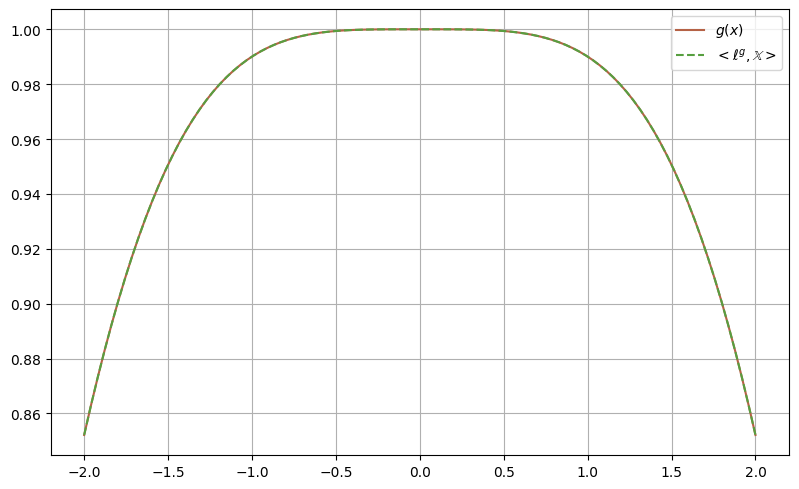

In [3]:
# # polynomial function
# coefs_array = np.zeros(N + 1)
# coefs_array[:5] = np.array([1, -1, 2, -3, 5])
# def g(x):
#     x = np.array(x)
#     p_shape = (1,) * len(x.shape) + (-1,)
#     x_shape = x.shape + (1,)
#     return (x.reshape(x_shape)**p_arr.reshape(p_shape) / factorials.reshape(p_shape)) @ coefs_array


# # Exponential function exp(ax)
# a = 0.5
# coefs_array = a**p_arr
# def g(x):
#     return np.exp(a * x)


# # Cosine function cos(ax)
# a = 2.0
# coefs_array = a**p_arr * (p_arr % 2 == 0) * (-1)**((p_arr // 2) % 2 == 1)
# def g(x):
#     return np.cos(a * x)

# # exp(ax^2)
# a = -0.2
# factorials_half = np.array([factorial(i // 2) for i in range(N + 1)])
# coefs_array = a**(p_arr // 2) * (p_arr % 2 == 0) * factorials / factorials_half
# def g(x):
#     return np.exp(a * x**2)

# exp(ax^4)
a = -0.01
factorials_quart = np.array([factorial(i // 4) for i in range(N + 1)])
coefs_array = a**(p_arr // 4) * (p_arr % 4 == 0) * factorials / factorials_quart
def g(x):
    return np.exp(a * x**4)

ell_g = ta.from_array(coefs_array, N, dim)
print(ell_g)

fig, ax = plt.subplots()
ax.plot(x_grid, g(x_grid), label="$g(x)$")
ax.plot(x_grid, ell_g.array @ x_arr, "--", label=r"$<\ell^g, \mathbb{X}>$")
ax.legend()
plt.show()

#### Monte Carlo solution

In [4]:
rng = np.random.default_rng(seed=42)

n_sample = 10**5
W_T = rng.normal(size=n_sample) * np.sqrt(T)

sample = g(x_grid[None, :] + W_T[:, None])
u_mc = sample.mean(axis=0)

#### Solution via quadratures

In [5]:
N_points = 50

z_arr, w_arr = roots_laguerre(n=N_points)

def f(x):
    return (g(x_grid[:, None] + np.sqrt(T) * x[None, :]) + g(x_grid[:, None] - np.sqrt(T) * x[None, :])) * np.exp(- 0.5 * x[None, :]**2) / np.sqrt(2 * np.pi)

u_quad = f(z_arr) @ (w_arr * np.exp(z_arr))

#### Via inf-dimensional Riccati

In [6]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=dim)
args = {"shuffle_table": shuffle_table}

In [7]:
@jax.jit
def heat_ode_fun(psi: ta.TensorSequence, args: dict) -> ta.TensorSequence:
    return psi.proj(11) * 0.5

@jax.jit
def riccati_ode_fun(psi: ta.TensorSequence, args: dict) -> ta.TensorSequence:
    return psi.proj(11) * 0.5 + ta.shuffle_pow(psi.proj(1), 2, args["shuffle_table"]) * 0.5

In [8]:
u_trunc = N
n = 1000
t_grid = np.linspace(0, T, n)

In [9]:
# fig, ax = plt.subplots(figsize=(12, 6))

step_fun = step_fun_pece # step_fun_euler

ell_arr = ode_solver_traj(fun=heat_ode_fun, step_fun=step_fun, t_grid=t_grid, init=ell_g, args=args)
ell_T = ell_arr.subsequence([-1,])
print((ell_T[0]))
# ta.plot_coefficients(psi_T, nonzero=True, ax=ax)

0.9928043529245338


#### Using the exact formula $u(T, \mathbb{X}) = \langle \ell^g, \mathbb{X}\otimes\mathcal{E}_T \rangle$

In [10]:
x_arr_sig = ta.from_array(x_arr, trunc=N, dim=dim)
e_sig = ta.tensor_exp(ta.from_word(word=11, trunc=N, dim=dim) * 0.5 * T)
e_sig = ta.from_array(e_sig.array[:, None] * jnp.ones((1, x_grid.size)), trunc=N, dim=dim)
X_times_esig = ta.tensor_prod(x_arr_sig, e_sig)

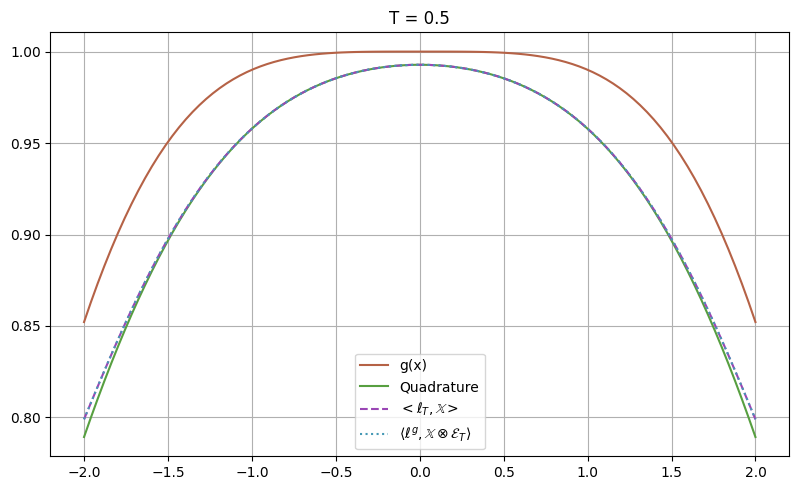

In [11]:
fig, ax = plt.subplots()

ax.plot(x_grid, g(x_grid), label="g(x)")


ax.plot(x_grid, u_quad, label="Quadrature")
# ax.plot(x_grid, u_mc, "--", label="MC")
ax.plot(x_grid, ell_T.array @ x_arr, "--", label=r"$<\ell_T, \mathbb{X}>$")
ax.plot(x_grid, ell_g.array @ X_times_esig.array, ":", label=r"$\langle \ell^g, \mathbb{X}\otimes\mathcal{E}_T \rangle$")

ax.set_title(f"T = {T}")
ax.legend()

# Comparing different methods: Riccati, Centered Riccati, Monte Carlo

In [25]:
T = 0.05          # time horizon
N = 19
dim = 1
e = ta.AlgebraBasis(dim=dim, trunc=N)
R = 1.147147147147147

r = 2
N_x_grid = 100
x_grid = np.linspace(-r, r, N_x_grid)

#### Via MC

In [6]:
u_coef = -24
pol = lambda x: u_coef * (x**4 / 24)

In [8]:
rng = np.random.default_rng(seed=42)
n_sample = 10**6
W_T = rng.normal(size=n_sample) * np.sqrt(T)
sample = np.exp(pol(x_grid[None, :] + W_T[:, None]))
cf_mc = sample.mean(axis=0)

#### Via inf-dimensional Riccati

In [11]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=dim)
args = {"shuffle_table": shuffle_table}

In [12]:
@jax.jit
def ode_fun(psi: ta.TensorSequence, args: dict) -> ta.TensorSequence:
    return psi.proj(11) * 0.5 + ta.shuffle_pow(psi.proj(1), 2, args["shuffle_table"]) * 0.5

In [13]:
u_trunc = N
n = 1000
t_grid = np.linspace(0, T, n)
u = ta.from_word(1111, trunc=u_trunc, dim=1) * (u_coef)

In [14]:
# fig, ax = plt.subplots(figsize=(12, 6))

step_fun = step_fun_pece # step_fun_euler

psi = ode_solver_traj(fun=ode_fun, step_fun=step_fun, t_grid=t_grid, init=u, args=args)
psi_T = psi.subsequence([-1,])
print(np.exp(psi_T[0]))
# ta.plot_coefficients(psi_T, nonzero=True, ax=ax)

0.9928039072775828


#### Centered inf-dimensional Riccati

In [15]:
shuffle_table = ta.get_shuffle_table(table_trunc=N, dim=dim)
args = {"shuffle_table": shuffle_table}

In [16]:
u_trunc = N
n = 1000
t_grid = np.linspace(0, T, n)
u = ta.from_word(1111, trunc=u_trunc, dim=1) * (u_coef)

In [17]:
dim_sig = ta.number_of_words_up_to_trunc(dim=dim, trunc=N)
proj_mat = np.zeros((dim_sig, dim_sig))

for i in range(dim_sig):
    v = ta.index_to_word(i, dim)
    proj_mat[i] = u.proj(v).array

In [18]:
factorials = np.array([factorial(i) for i in range(N + 1)])
x_arr = (x_grid[None, :] ** np.arange(N + 1)[:, None]) / factorials[:, None]
u_left_proj_x_arr = x_arr.T @ proj_mat

In [19]:
@jax.jit
def ode_fun(psi: ta.TensorSequence, args: dict) -> ta.TensorSequence:
    return psi.proj(11) * 0.5 + ta.shuffle_pow(psi.proj(1), 2, args["shuffle_table"]) * 0.5

In [20]:
psi_centered_arr = np.zeros_like(x_grid)

for i, u_x in enumerate(u_left_proj_x_arr):
    u_left_proj_x = ta.from_array(u_x, N, dim)
    step_fun = step_fun_pece # step_fun_euler

    psi_centered = ode_solver_traj(fun=ode_fun, step_fun=step_fun, t_grid=t_grid, init=u_left_proj_x, args=args)
    psi_T_centered = psi_centered.subsequence([-1,])
    psi_centered_arr[i] = psi_T_centered[0]

#### Plotting all the results

In [22]:
shuffle_exp_psi = ta.shuffle_exp(psi_T, shuffle_table)

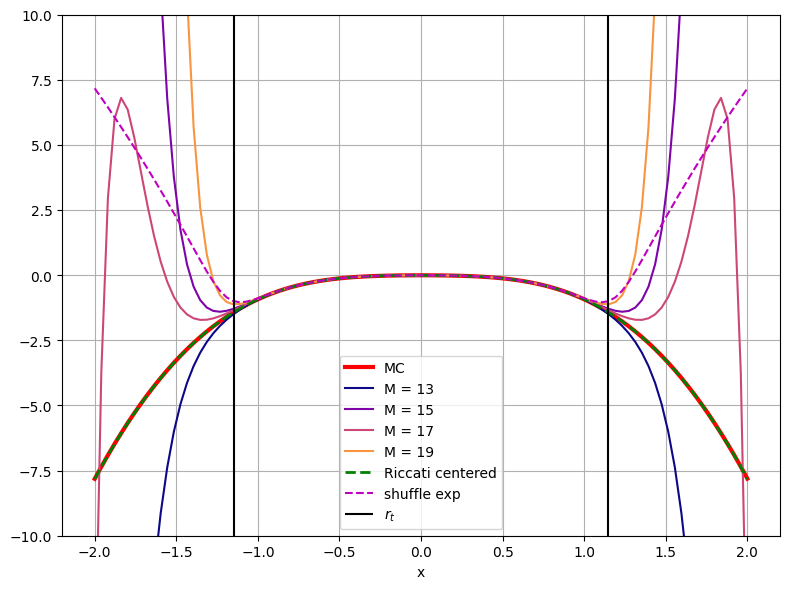

In [26]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cmap = plt.cm.plasma

factorials = np.array([factorial(i) for i in range(N + 1)])
x_arr = (x_grid[None, :] ** np.arange(N + 1)[:, None]) / factorials[:, None]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_grid, np.log(cf_mc), "r", label="MC", lw=3)

ran = np.arange(N-6, N+1, 2)
L = len(ran)
for i, trunc in enumerate(ran):
    ax.plot(x_grid, np.real(psi_T.array[:trunc + 1] @ x_arr[:trunc + 1]), label=f"M = {trunc}", color=cmap(norm(i / L)))
ax.set_xlabel("x")

ax.plot(x_grid, psi_centered_arr, "g--", label="Riccati centered", lw=2)

ax.plot(x_grid, np.log(shuffle_exp_psi.array @ x_arr), "m--", label="shuffle exp")

y_lim_1, y_lim_2 = -10, 10

ax.vlines(R, y_lim_1, y_lim_2, "k", label="$r_t$")
ax.vlines(-R, y_lim_1, y_lim_2, "k")

ax.set_ylim([y_lim_1, y_lim_2])
ax.legend()

fig.tight_layout()
plt.savefig("images/riccati_zeros/psi_series.pdf", format="pdf", transparent=True)